## 01_gsw_tools.ipynb
---


This notebook uses the Gibbs-SeaWater (GSW) Oceanographic Toolbox containing the TEOS-10 subroutines for evaluating the thermodynamic properties of seawater. Specifically we are going to calculate: 

**1.** Absolute Salinity ($S_A$) from Argo practical salinity 

**2.** Conservative Temperature ($\theta$) from Argo in-situ temperature 

**3.** Potential Density Anomaly ($\sigma_t$) with reference pressure of 0 dbar using the calculated $S_A$ and $\theta$

Anomalies in $S_A$, $\theta$, and $\sigma_t$ are computed by removing the long-term (January 2004 – December 2020) monthly mean at each space and pressure point.

### Roemmich and Gilson Argo Climatology

The data we are using is from the updated **[Roemmich and Gilson (RG) Argo Climatology](http://sio-argo.ucsd.edu/RG_Climatology.html)** from the Scripps Instition of Oceanography. This data contains monthly ocean temperature and salinity on 58 levels from 2.5 to 2000 dbars from January 2004 through present. The RG climatology has a regular global 1 degree grid and is available as NetCDF only. It contains only data from Argo floats using optimal interpolation. This data product is described in further detail in [Roemmich and Gilson (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0079661109000160?via%3Dihub)

In [148]:
import xarray as xr
import dask 
import gsw
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [15]:
# Import the netCDF files that are downloaded when running 01_get_data.sh from the command line

data_path = '/glade/scratch/scanh/RG-argo-climatology/*'
dask.config.set({"array.slicing.split_large_chunks": False})
ds = xr.open_mfdataset(data_path, decode_times=False)
# ds = ds.loc[dict(lat=slice(10, 65), lon=slice(180, 260))]
dyr = ds.TIME
dates = np.arange('2004-01', '2021-01', dtype='datetime64[M]')
ds = ds.assign(TIME = dates)
ds

<xarray.Dataset>
Dimensions:                   (LATITUDE: 145, LONGITUDE: 360, PRESSURE: 58, TIME: 204)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2004-01-01 ... 2020-12-01
  * LONGITUDE                 (LONGITUDE) float32 20.5 21.5 22.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 -64.5 -63.5 -62.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 2.5 10.0 20.0 ... 1900.0 1975.0
Data variables:
    ARGO_SALINITY_MEAN        (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>
    ARGO_SALINITY_ANOMALY     (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(181, 58, 145, 360), meta=np.ndarray>
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(204, 58, 145, 360), meta=np.ndarray>
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(58, 145, 360), meta=np.ndarray>

In [132]:
argo_tot = ds.ARGO_TEMPERATURE_ANOMALY + ds.ARGO_TEMPERATURE_MEAN
climatology = argo_tot.groupby('TIME.month').mean()
climatology.shape

(12, 58, 145, 360)

In [137]:
climatology

<xarray.DataArray (month: 12, PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360)>
dask.array<stack, shape=(12, 58, 145, 360), dtype=float32, chunksize=(1, 58, 145, 360), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [144]:
argo_anom = np.empty((ds.ARGO_TEMPERATURE_ANOMALY.shape[0], ds.ARGO_TEMPERATURE_ANOMALY.shape[1], ds.ARGO_TEMPERATURE_ANOMALY.shape[2], ds.ARGO_TEMPERATURE_ANOMALY.shape[3])) 
argo_anom[:] = np.nan
for i in enumerate(climatology.month.values):
    I = np.where(ds.TIME.dt.month == i[1])[0]
    argo_anom[I] = argo_tot[I,:,:,:] - climatology[i[0],:,:,:]
    
    
    

In [149]:
argo_anom = argo_tot - climatology
argo_anom

<xarray.DataArray (TIME: 204, PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360, month: 12)>
dask.array<sub, shape=(204, 58, 145, 360, 12), dtype=float32, chunksize=(204, 58, 145, 360, 1), chunktype=numpy.ndarray>
Coordinates:
  * TIME       (TIME) datetime64[ns] 2004-01-01 2004-02-01 ... 2020-12-01
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

/glade/u/home/scanh/miniconda3/envs/scannell-grl2020/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ValueError: too many values to unpack (expected 2)

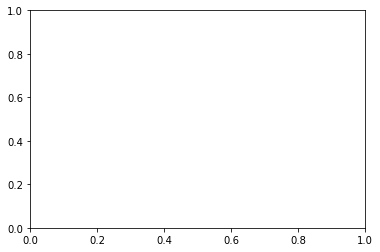

In [147]:
plt.pcolormesh(argo_anom[0,0,:,:]); plt.colorbar()

In [ ]:
 def compute_anomalies(ds):
        argo_tot = ds.ARGO_TEMPERATURE_ANOMALY + ds.ARGO_TEMPERATURE_MEAN
        climatology = argo_tot.groupby('TIME.month').mean()
        argo_anom = argo_tot - climatology
        return argo_anom
    
    argo_anom = xr.apply_ufunc(compute_anomalies, ds,
                               input_core_dims=[['PRESSURE','LATITUDE', 'LONGITUDE']],
                               output_core_dims=[['PRESSURE','LATITUDE', 'LONGITUDE']],
                               output_dtypes=[ds.dtype],
                               vectorize=True,
                               dask='parallelized')
    
    
    
    def anomalies(bitmap_binary):
        bitmap_binary_padded = np.pad(bitmap_binary,
                                      ((diameter, diameter), (diameter, diameter)),
                                      mode='reflect')
        s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
        s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
        unpadded= s2[diameter:-diameter, diameter:-diameter]
        return unpadded
    
    mo_binary = xr.apply_ufunc(binary_open_close, bitmap_binary,
                               input_core_dims=[['lat', 'lon']],
                               output_core_dims=[['lat', 'lon']],
                               output_dtypes=[bitmap_binary.dtype],
                               vectorize=True,
                               dask='parallelized')


---
### **1**. Absolute Salinity ($S_A$) from Practical Salinity.

    gsw.SA_from_SP(SP, p, lon, lat)
    
Calculates Absolute Salinity from Practical Salinity. Since SP is non-negative by definition, this function changes any negative input values of SP to be zero.

**Parameters**:
- *SP* array-like Practical Salinity (PSS-78), unitless
- $p$ array-like Sea pressure (absolute pressure minus 10.1325 dbar), dbar
- $lon$ array-like Longitude, -360 to 360 degrees
- $lat$ array-like Latitude, -90 to 90 degrees

**Returns**:
- Absolute Salinity ($S_A$) array-like, g/kg Absolute Salinity

In [11]:
test = gsw.SA_from_SP(ds.sa_tot.values, ds.pressure[:].values, 360-ds.lon.values, ds.lat.values)


AttributeError: 'Dataset' object has no attribute 'sa_tot'

In [ ]:
%%time 
SA_tot = np.empty((ds.sa_tot.shape[0], ds.sa_tot.shape[1], ds.sa_tot.shape[2], ds.sa_tot.shape[3])) 
SA_tot[:] = np.nan

# Compute Absolute Salinity
for la in np.arange(0, ds.lat.shape[0]): 
    for lo in np.arange(0, ds.lon.shape[0]): 
        SA_tot[:,:,la,lo] = gsw.SA_from_SP(ds.sa_tot[:,:,la,lo].values, ds.pressure[:].values, 360-ds.lon[lo].values, ds.lat[la].values)
